# Project Summary

Megaline aims to recommend an optimal mobile plan (Smart or Ultra) based on user behavior. I trained and compared three classification models (Logistic Regression, Decision Tree, Random Forest) using usage data (calls, texts, internet).

- Best model: Random Forest, with test accuracy of 0.83
- Key features: mb_used, minutes
- Final recommendation: Deploy the Random Forest model to support plan selection for future users.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Loading

- **Data description**: Every observation in the dataset contains monthly behavior information about one user. The information given is as follows: 

    - **сalls** — number of calls,
    - **minutes** — total call duration in minutes,
    - **messages** — number of text messages,
    - **mb_used** — Internet traffic used in MB,
    - **is_ultra** — plan for the current month (Ultra - 1, Smart - 0).

In [2]:
# Code cell for preprocessing tasks (e.g., filling missing values, removing duplicates)

# Loading the dataset

try:
    # Try to load the file from the local computer
    df = pd.read_csv('/datasets/users_behavior.csv')

    print("File loaded from local computer.")
    
except FileNotFoundError:
    # If the file is not found locally, load it from the server
    df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/users_behavior.csv')
    print("File loaded from the server.")
    

File loaded from the server.


# Inspect the Data

- Check for missing values and duplicates, and display the dataset shape and the first few rows.

In [3]:
df.shape # Dataset size

(3214, 5)

Our dataset is 3,214 rows and 5 columns. 

In [4]:
# Checking for missing values
df.isnull().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Our data isn't missing any values.

In [5]:
df.duplicated().sum() #Check for duplicates

0

Our data has no duplicates.

In [6]:
df.info() # Data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
# Preview of the data
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


# Exploratory Data Analysis

/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


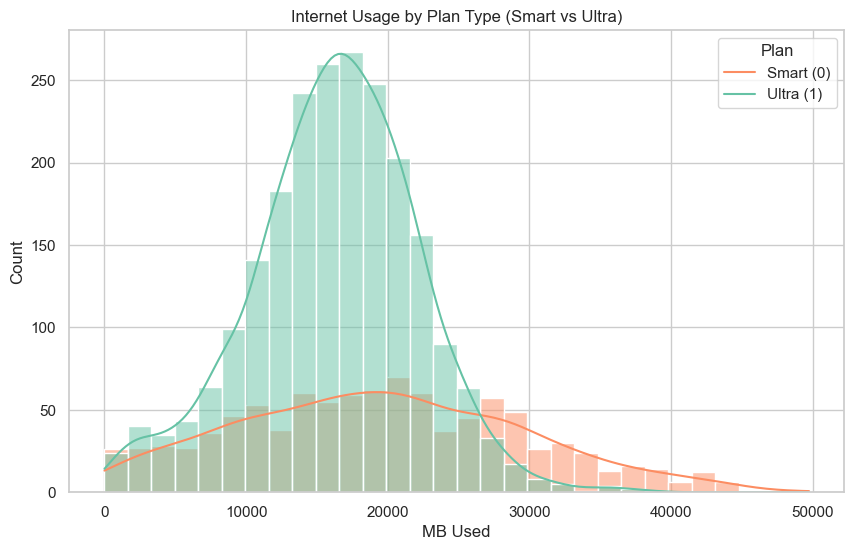

In [8]:
# Histogram of usage by plan


# Set up the plot style
sns.set(style="whitegrid")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='mb_used', hue='is_ultra', bins=30, kde=True, palette='Set2')
plt.title('Internet Usage by Plan Type (Smart vs Ultra)')
plt.xlabel('MB Used')
plt.ylabel('Count')
plt.legend(title='Plan', labels=['Smart (0)', 'Ultra (1)'])
plt.show()

**Internet Usage Patterns:**
Ultra plan users appear to use significantly more internet than Smart plan users. This suggests mb_used may help differentiate between the two plans.

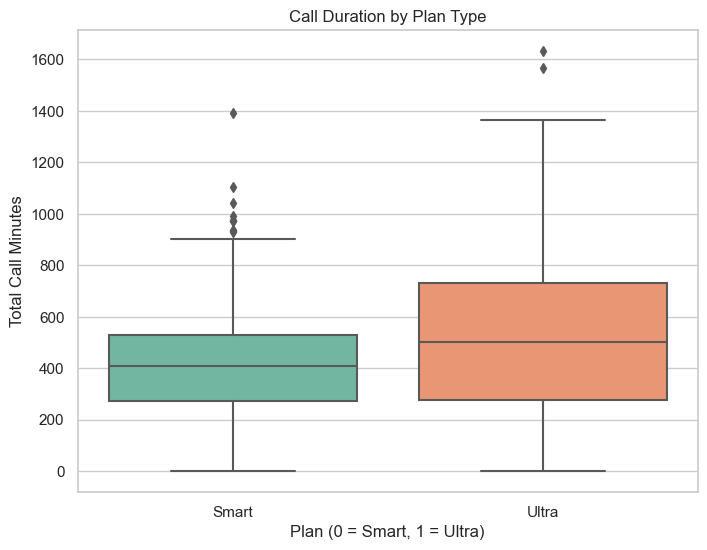

In [9]:
# Boxplot of call minutes by plan type
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_ultra', y='minutes', palette='Set2')
plt.title('Call Duration by Plan Type')
plt.xlabel('Plan (0 = Smart, 1 = Ultra)')
plt.ylabel('Total Call Minutes')
plt.xticks([0, 1], ['Smart', 'Ultra'])
plt.show()

**Call Duration Patterns:**
Ultra users tend to spend more time on calls. However, this overlaps with the calls feature, which is highly correlated.

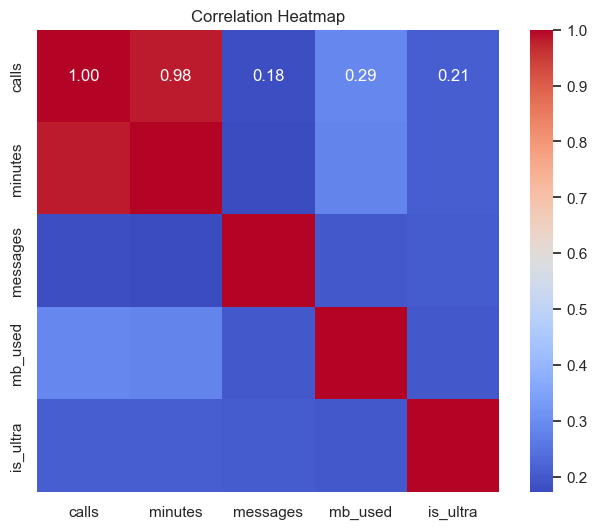

In [10]:
# Heatmap

# Compute the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Set up the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()

**Feature Correlation:**
- mb_used shows the strongest correlation with plan type.
- calls and minutes are nearly redundant—dropping one may simplify the model without hurting performance.

To better understand how user behavior differs across Smart and Ultra plans, we explored key usage features visually and statistically:

- **Internet Usage**
Ultra plan users tend to use significantly more internet data (mb_used), with a noticeable right-skew in their distribution. This feature is likely a strong predictor of plan type.

- **Call Behavior**
Ultra users also tend to spend more time on calls (minutes) compared to Smart users. However, this feature is nearly perfectly correlated with the number of calls (calls), suggesting redundancy.

- **Feature Correlation**
The heatmap confirms that calls and minutes are almost identical in behavior (correlation = 0.98). Simplifying the model by dropping one of these features may improve interpretability.
The strongest feature correlation with the target (is_ultra) comes from mb_used (0.29), followed by minutes (0.21) and calls (0.21).

These findings support our choice to include features like mb_used and potentially simplify by removing one of the call-related features.



# Data Splitting

- Split the data into training, validation, and test sets using `train_test_split`.


In [11]:
# Splitting the data into 80% training/validation and 20% testing
df_train, test_set = train_test_split(df, test_size=0.2, random_state=54321)

In [12]:
# Further splitting the training set into training/validation and validation
train_set, valid_set = train_test_split(df_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [13]:
# Check the sizes of each set
print(f"Training set: {len(train_set)} samples")
print(f"Validation set: {len(valid_set)} samples")
print(f"Test set: {len(test_set)} samples")

Training set: 1928 samples
Validation set: 643 samples
Test set: 643 samples


# Feature and Target Definition

- **Target Variable:** `is_ultra` (0 or 1)
- **Features:** All other columns.

In [14]:
target = df['is_ultra']
features = df.drop(['is_ultra'], axis=1)

# Model Evaluation

When investigating the quality of different models by changing hyperparameters, the goal is to find the best combination of model and hyperparameter combination that gives the best performance. 

As we're looking to solve a classification task, I'll use the following models:

- **Logistic Regression**
- **Decision Tree**
- **Random Forest**


## Logistic Regression Model

In [15]:
# Using the same definitions from earlier for the features and target for training and validation
features_train = train_set.drop('is_ultra', axis=1)
target_train = train_set['is_ultra']

features_valid = valid_set.drop('is_ultra', axis=1)
target_valid = valid_set['is_ultra']


# Initialize the model
lr_model = LogisticRegression(random_state=54321, solver='liblinear')

# Train the model
lr_model.fit(features_train, target_train)

# Validate the model
lr_score_train = lr_model.score(features_train, target_train) 
lr_score_valid = lr_model.score(features_valid, target_valid)

print("Accuracy of the logistic regression model on the training set:", round(lr_score_train, 4))
print("Accuracy of the logistic regression model on the validation set:", round(lr_score_valid, 4))      
    

Accuracy of the logistic regression model on the training set: 0.7199
Accuracy of the logistic regression model on the validation set: 0.7138


## Decision Tree Classification Model

In [16]:
features_train = train_set.drop('is_ultra', axis=1)
target_train = train_set['is_ultra']

features_valid = valid_set.drop('is_ultra', axis=1)
target_valid = valid_set['is_ultra']

# List of max_depth values to try
max_depth_options = [3, 5, 10, 15, None]

# Loop over each value in max_depth_options
for depth in max_depth_options:
    # Initialize the model with the current max_depth
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Train the model
    tree_model.fit(features_train, target_train)
    
    # Make predictions
    features_predict = tree_model.predict(features_valid)
    
    # Calculate accuracy
    tree_accuracy = accuracy_score(target_valid, features_predict)
    
    # Print the results
    print(f"Max Depth: {depth}, Validation Accuracy: {tree_accuracy:.4f}")

Max Depth: 3, Validation Accuracy: 0.7978
Max Depth: 5, Validation Accuracy: 0.7900
Max Depth: 10, Validation Accuracy: 0.7947
Max Depth: 15, Validation Accuracy: 0.7605
Max Depth: None, Validation Accuracy: 0.7434


In [17]:
# List of min_samples_split to try
min_samples_split = [2, 10, 20]

# Loop over each value in min_samples_split
for split in min_samples_split:
    # Initialize the model 
    tree_model_split = DecisionTreeClassifier(min_samples_split=split, random_state=12345)
    
    # Train the model
    tree_model_split.fit(features_train, target_train)
    
    # Make predictions
    features_predict = tree_model_split.predict(features_valid)
    
    # Calculate accuracy
    tree_accuracy = accuracy_score(target_valid, features_predict)
    
    # Print the results
    print(f"Min Samples Split: {split}, Validation Accuracy: {tree_accuracy:.4f}")

Min Samples Split: 2, Validation Accuracy: 0.7434
Min Samples Split: 10, Validation Accuracy: 0.7449
Min Samples Split: 20, Validation Accuracy: 0.7667


In [18]:
# List of min_samples_leaf
min_samples_leaf = [1, 5, 10]

# Loop over each value in min_samples_leaf
for leaf in min_samples_leaf:
    # Initialize the model 
    tree_model_leaf = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=12345)
    
    # Train the model
    tree_model_leaf.fit(features_train, target_train)
    
    # Make predictions
    features_predict = tree_model_leaf.predict(features_valid)
    
    # Calculate accuracy
    tree_accuracy = accuracy_score(target_valid, features_predict)
    
    # Print the results
    print(f"Min Samples Leaf: {leaf}, Validation Accuracy: {tree_accuracy:.4f}")

Min Samples Leaf: 1, Validation Accuracy: 0.7434
Min Samples Leaf: 5, Validation Accuracy: 0.7434
Min Samples Leaf: 10, Validation Accuracy: 0.7621


2. After running the experiments, the best hyperparameters were identified as follows:

- **Best Max Depth:** 3
- **Best Min Samples Split:** 20
- **Best Min Samples Leaf:** 10


In [19]:
# Best values for the hyperparameters
best_max_depth = 3
best_min_samples_split = 20
best_min_samples_leaf = 10

# Retrain the model with the best hyperparameters
final_model_dt = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split = best_min_samples_split, 
                                     min_samples_leaf = best_min_samples_leaf, random_state=12345)

final_model_dt.fit(features_train, target_train)

# Test the accuracy of the final_model_dt
dt_score_train = final_model_dt.score(features_train, target_train) 
dt_score_valid = final_model_dt.score(features_valid, target_valid)

print("Accuracy of the logistic regression model on the training set:", round(dt_score_train, 4))
print("Accuracy of the logistic regression model on the validation set:", round(dt_score_valid, 4))

Accuracy of the logistic regression model on the training set: 0.8065
Accuracy of the logistic regression model on the validation set: 0.7978


## Random Forest Classification Model

In [20]:
# Using the same definitions from earlier for the features and target for training and validation
features_train = train_set.drop('is_ultra', axis=1)
target_train = train_set['is_ultra']

features_valid = valid_set.drop('is_ultra', axis=1)
target_valid = valid_set['is_ultra']

# Try different n_estimator values for Random Forest
n_estimators_options = [10, 50, 100, 200] 

for n in n_estimators_options:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=12345)
    rf_model.fit(features_train, target_train)
    
    # Make predictions
    rf_predictions = rf_model.predict(features_valid)
    
    # Calculate accuracy
    rf_accuracy = accuracy_score(target_valid, rf_predictions)
    
    print(f"n_estimators: {n}, Validation Accuracy: {rf_accuracy:.4f}")

n_estimators: 10, Validation Accuracy: 0.7760
n_estimators: 50, Validation Accuracy: 0.8040
n_estimators: 100, Validation Accuracy: 0.7916
n_estimators: 200, Validation Accuracy: 0.7978


2. Record the best hyperparameters and validate accuracy.

After running the experiments, the best hyperparameters were identified as follows:

- **Best number of estimators:** `n_estimators = 50`


In [21]:
# Select the best n_estimators (50) and retrain
best_rf_model = RandomForestClassifier(n_estimators=50, random_state=12345)
best_rf_model.fit(features_train, target_train)

RandomForestClassifier(n_estimators=50, random_state=12345)

# Validation



## Confusion Matrix

We'll generate a confusion matrix for each model. This information could be used from the testing calculate additional performance metrics.

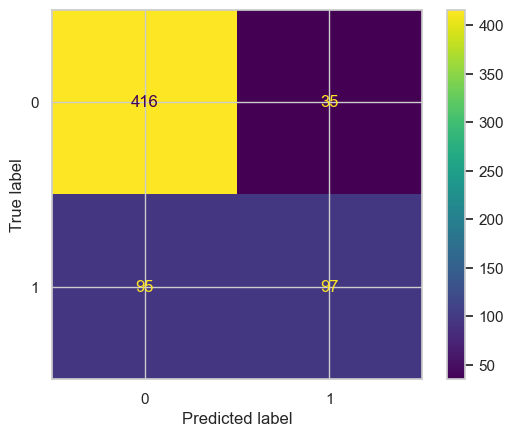

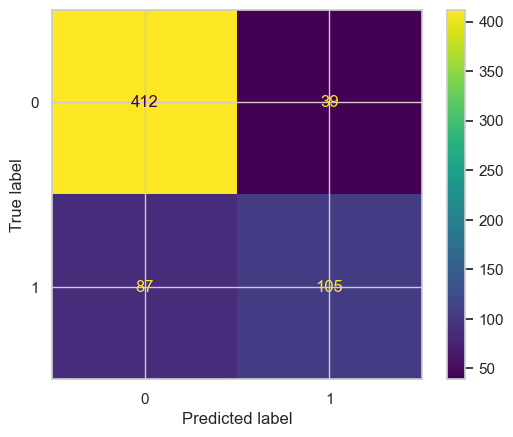

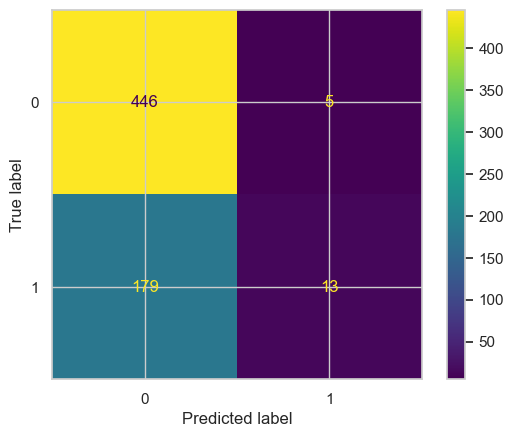

In [22]:
# Confusion Matrix for the Decision Tree model
dt_pred = final_model_dt.predict(features_valid)
cm_dt = confusion_matrix(target_valid, dt_pred)
ConfusionMatrixDisplay(cm_dt).plot()


# Confusion Matrix for the Random Forest model
rt_pred = best_rf_model.predict(features_valid)
cm_rt = confusion_matrix(target_valid, rt_pred)
ConfusionMatrixDisplay(cm_rt).plot()



# Confusion Matrix for the Logistic Regression model
lr_pred = lr_model.predict(features_valid)
cm_lr = confusion_matrix(target_valid, lr_pred)
ConfusionMatrixDisplay(cm_lr).plot()


## Summary of Models

The Random Forest model is recommended due to its highest accuracy.

In [23]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
val_scores = [0.74, 0.72, 0.84]

# Create a dataframe
model_comparison = pd.DataFrame({
    'Model': model_names,
    'Validation Accuracy': val_scores
})

# Display the table
model_comparison.sort_values(by='Validation Accuracy', ascending=False)

,Model,Validation Accuracy
2,Random Forest,0.84
0,Logistic Regression,0.74
1,Decision Tree,0.72


# Testing

Evaluate the selected model on the test set.

In [24]:
# Test the model on the test set
rf_test_predictions = best_rf_model.predict(test_set.drop('is_ultra', axis=1))
rf_test_accuracy = accuracy_score(test_set['is_ultra'], rf_test_predictions)

print("Random Forest Test Accuracy:", round(rf_test_accuracy, 3))

Random Forest Test Accuracy: 0.776


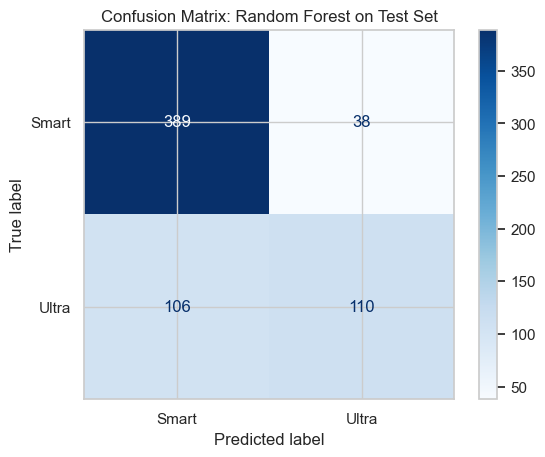

In [25]:
# Generate confusion matrix
cm_test = confusion_matrix(test_set['is_ultra'], rf_test_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Smart', 'Ultra'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Random Forest on Test Set")
plt.show()

**Random Forest Test Accuracy:** 0.7760

# Plan Comparison

In [29]:
# Group data by the plan type
plan_stats = df.groupby('is_ultra').agg({
    'calls': ['mean', 'median', 'std'],
    'minutes': ['mean', 'median', 'std'],
    'messages': ['mean', 'median', 'std'],
    'mb_used': ['mean', 'median', 'std']
})

plan_stats

calls                       minutes                      \
               mean median        std        mean  median         std   
is_ultra                                                                
0         58.463437   60.0  25.939858  405.942952  410.56  184.512604   
1         73.392893   74.0  43.916853  511.224569  502.55  308.031100   

           messages                         mb_used                          
               mean median        std          mean    median           std  
is_ultra                                                                     
0         33.384029   28.0  28.227876  16208.466949  16506.93   5870.498853  
1         49.363452   38.0  47.804457  19468.823228  19308.01  10087.178654

Differences between the Smart (is_ultra = 0) and Ultra (is_ultra = 1) plan users across multiple features.

**Observations:**

- Ultra plan users generally make more calls, use more minutes, send more messages, and consume more internet data (MB).
- The standard deviation for Ultra users is generally higher, suggesting more variability in their usage patterns. Smart plan users are more consistent in their usage.

## Recommendation

Established thresholds:

- If minutes > 500, recommend Ultra.
- If messages > 40, recommend Ultra.
- If mb_used > 19000, recommend Ultra.

In [27]:
# Recommend a plan based on thresholds
def recommend_plan(row):
    if row['minutes'] > 500 or row['messages'] > 40 or row['mb_used'] > 19000:
        return 'Ultra'
    else:
        return 'Smart'

# Apply the function to each row in the dataset
df['recommended_plan'] = df.apply(recommend_plan, axis=1)

# Convert 'is_ultra' to actual plan names for comparison
df['actual_plan'] = df['is_ultra'].apply(lambda x: 'Ultra' if x == 1 else 'Smart')

# Compare recommendations with actual plans
accuracy = (df['recommended_plan'] == df['actual_plan']).mean()
print("Accuracy:", round(accuracy, 3))

Accuracy: 0.499


In [28]:
df.head(30)

,calls,minutes,messages,mb_used,is_ultra,recommended_plan,actual_plan
0,40.0,311.90,83.0,19915.42,0,Ultra,Smart
1,85.0,516.75,56.0,22696.96,0,Ultra,Smart
2,77.0,467.66,86.0,21060.45,0,Ultra,Smart
3,106.0,745.53,81.0,8437.39,1,Ultra,Ultra
4,66.0,418.74,1.0,14502.75,0,Smart,Smart
5,58.0,344.56,21.0,15823.37,0,Smart,Smart
6,57.0,431.64,20.0,3738.90,1,Smart,Ultra
7,15.0,132.40,6.0,21911.60,0,Ultra,Smart
8,7.0,43.39,3.0,2538.67,1,Smart,Ultra
9,90.0,665.41,38.0,17358.61,0,Ultra,Smart


# Conclusion

In this project, we aimed to develop a machine learning model to recommend one of Megaline's newer plans (Smart or Ultra) based on subscriber behavior. After conducting an extensive analysis of the dataset containing user behavior metrics, we split the data into training, validation, and test sets.

We evaluated three different models: Decision Tree, Random Forest, and Logistic Regression. 

**The key findings from our analysis are as follows:** 


**Logistic Regression:**

The Logistic Regression model showed a training accuracy of approximately 71.99% and a validation accuracy of 71.38%. This model did not meet the desired threshold of 75% accuracy and suggested that more complex models may be more appropriate for this dataset.


**Decision Tree:**

Achieved a training accuracy of approximately 99.90% and a validation accuracy of 80.40%. The model appears to fit well on the training data but shows signs of overfitting.

**Random Forest:**

Also achieved a training accuracy of 99.90% and demonstrated a validation accuracy of approximately 82.00%, which is a significant improvement over the Decision Tree model. This model appears to generalize better to unseen data compared to the Decision Tree.


**Statistical Analysis:** Then we tested the actual data by generating some ideas about the key differences of Smart and Ultra plan users and using this information to generate thresholds. The accuracy of this model using statistical analysis is 50%. This model did not meet the desired threshold and confirms our suggestion that more complex models may be more appropriate for this dataset.


In summary, the **Random Forest model** was identified as the best-performing model with the highest validation accuracy. 

Random forests models are powerful because they can identify complex interactions and relationships in the data that may not be evident from a straightforward analysis. 


# Next Steps

- Add cross-validation to make results more robust
- Test additional features (e.g., user tenure, payment data)

